<a href="https://colab.research.google.com/github/COHMAM/HW/blob/main/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BF%D0%BE_%D1%82%D0%B5%D0%BC%D0%B5_%C2%AB%D0%90%D1%80%D1%85%D0%B8%D1%82%D0%B5%D0%BA%D1%82%D1%83%D1%80%D1%8B_%D1%81%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9%C2%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#датасет EMNIST из torchvision

In [ ]:
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary
import time

In [ ]:
import tracemalloc
import time

In [ ]:
from torchvision.transforms import v2

import pandas as pd

import matplotlib.pyplot as plt


In [ ]:
BATCH_SIZE = 32
transforms = tv.transforms.Compose([
    #v2.ToPILImage(),
    v2.Grayscale(3),
    v2.Resize((299, 299)),
    v2.ToTensor(),
    #v2.ToImage()
])



train_dataset_3 = tv.datasets.MNIST('.', train=True, transform=transforms, download=True)
#x_train = train_dataset_for_3channel.data[:10000]
#y_train = train_dataset_for_3channel.targets[:10000]
test_dataset_3 = tv.datasets.MNIST('.', train=False, transform=transforms, download=True)
#x_test = test_dataset_for_3channel.data[:5000]
#y_test = test_dataset_for_3channel.targets[:5000]
#set_train = list(zip(x_train,y_train))
#set_test = list(zip(x_test,y_test))
train_iter_3 = torch.utils.data.DataLoader(train_dataset_3, batch_size=BATCH_SIZE)
test_iter_3 = torch.utils.data.DataLoader(test_dataset_3, batch_size=BATCH_SIZE)

#ResNet 18, VGG 16, Inception v3, DenseNet 161

## Функции для задания

In [ ]:
def evaluate_accuracy(data_iter, net, spisok_test_loss, spisok_test_accuracy):
    acc_sum, n = 0, 0
    net.eval()
    test_iters = 0
    test_loss = 0
    loss = nn.CrossEntropyLoss(reduction='sum')

    for i,(X, y) in enumerate(data_iter):
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        l = loss(net(X), y)
        test_loss += l.item()

        n += y.shape[0]
        if acc_sum.item()>0.8:
          break

    spisok_test_accuracy.append(acc_sum.item()/n)
    spisok_test_loss.append(test_loss/(i+1))
    return spisok_test_accuracy, spisok_test_loss #acc_sum.item() / n, spisok_test_loss, spisok_test_accuracy#, test_loss/i+1

In [ ]:
Models = {}
Models['Timer'] = []
Models['RAM_current'] = []
Models['RAM_peak'] = []
Models['epoch'] = []
Models['Name_model'] = []
Models['spisok_train_loss'] = []
Models['spisok_train_accuracy'] = []
Models['spisok_test_loss'] = []
Models['spisok_test_accuracy'] = []

def train(net, train_iter, test_iter, trainer, num_epochs,name_model = None, spisok_loss=None, models = Models):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    st = time.time()
    for epoch in range(num_epochs):
          train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

          tracemalloc.start()
          spisok_train_loss = []
          spisok_train_accuracy = []
          spisok_test_loss = []
          spisok_test_accuracy = []

          for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            #spisok_train_loss.append(l.item())

            if (i % 100 == 0) and (train_acc_sum / n > 0.9):
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
              spisok_test_accuracy, spisok_test_loss = evaluate_accuracy(test_iter, net.to(device), spisok_test_loss, spisok_test_accuracy)

              spisok_train_loss.append(train_l_sum/n)
              spisok_train_accuracy.append(train_acc_sum/n)
              break
            elif i % 100 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
              spisok_test_accuracy, spisok_test_loss = evaluate_accuracy(test_iter, net.to(device), spisok_test_loss, spisok_test_accuracy)
              spisok_train_loss.append(train_l_sum/n)
              spisok_train_accuracy.append(train_acc_sum/n)

        #test_acc,test_loss, number_iter_test,spisok_test_loss = evaluate_accuracy(test_iter, net.to(device))
            #print('-' * 20)
          #print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
          #f', test acc {spisok_test_accuracy[i]:.3f}, test_loss {spisok_test_loss[i]:.3f}, time {time.time() - start:.1f} sec')



    #Models['layers'].append(model)
          et = time.time()
          Models['Timer'].append(round((et-st)/60,3))
          Models['Timer'].append(f'end_epochs_for {name_model} in {epoch}')
          #Models['train_loss'].append(round(train_l_sum/n,3))#train_loss/train_iters,3))
          #Models['test_loss'].append(round(test_loss,3))#test_loss/test_iters,3))
          #Models['train_acc'].append(round(train_acc_sum/n,3))
          #Models['test_acc'].append(round(test_acc,3))
          current, peak = tracemalloc.get_traced_memory()
          Models['RAM_current'].append(round(current/ 10**6,3))
          Models['RAM_current'].append(f'end_epochs_for {name_model} in {epoch}')

          Models['RAM_peak'].append(round(peak/ 10**6,3))
          Models['RAM_peak'].append(f'end_epochs_for {name_model} in {epoch}')

          Models['epoch'].append(epoch)
          Models['epoch'].append(f'end_epochs_for {name_model} in {epoch}')

          Models['Name_model'].append(name_model)
          Models['Name_model'].append(f'end_epochs_for {name_model} in {epoch}')

        #Models['number_iteration_train'] = i + 1
        #Models['number_iteration_test'] = number_iter_test
          Models['spisok_train_loss'].append(spisok_train_loss)
          Models['spisok_train_loss'].append(f'end_epochs_for {name_model} in {epoch}')

          Models['spisok_train_accuracy'].append(spisok_train_accuracy)
          Models['spisok_train_accuracy'].append(f'end_epochs_for {name_model} in {epoch}')

          Models['spisok_test_loss'].append(spisok_test_loss)
          Models['spisok_test_loss'].append(f'end_epochs_for {name_model} in {epoch}')

          Models['spisok_test_accuracy'].append(spisok_test_accuracy)
          Models['spisok_test_accuracy'].append(f'end_epochs_for {name_model} in {epoch}')

    return Models

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

##ResNet 18

In [ ]:
model = tv.models.resnet18(pretrained=True)

In [ ]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
model.fc = nn.Linear(in_features=512, out_features=10)

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
train(model,train_iter_3, test_iter_3, trainer=trainer, num_epochs = 10 , name_model = 'res_net')

Step 0. time since epoch: 0.164. Train acc: 0.094. Train Loss: 2.414
Step 100. time since epoch: 15.336. Train acc: 0.651. Train Loss: 1.633
Step 200. time since epoch: 30.351. Train acc: 0.760. Train Loss: 1.261
Step 300. time since epoch: 45.146. Train acc: 0.804. Train Loss: 1.059
Step 400. time since epoch: 60.054. Train acc: 0.831. Train Loss: 0.918
Step 500. time since epoch: 74.954. Train acc: 0.848. Train Loss: 0.824
Step 600. time since epoch: 90.250. Train acc: 0.865. Train Loss: 0.744
Step 700. time since epoch: 105.224. Train acc: 0.876. Train Loss: 0.681
Step 800. time since epoch: 120.188. Train acc: 0.885. Train Loss: 0.632
Step 900. time since epoch: 134.997. Train acc: 0.891. Train Loss: 0.594
Step 1000. time since epoch: 150.403. Train acc: 0.895. Train Loss: 0.563
Step 1100. time since epoch: 165.252. Train acc: 0.900. Train Loss: 0.533
Step 0. time since epoch: 0.147. Train acc: 0.969. Train Loss: 0.287
Step 0. time since epoch: 0.142. Train acc: 0.969. Train Loss: 

{'Timer': [2.757,
  'end_epochs_for res_net in 0',
  2.763,
  'end_epochs_for res_net in 1',
  2.769,
  'end_epochs_for res_net in 2',
  2.774,
  'end_epochs_for res_net in 3',
  2.78,
  'end_epochs_for res_net in 4',
  2.786,
  'end_epochs_for res_net in 5',
  2.792,
  'end_epochs_for res_net in 6',
  2.797,
  'end_epochs_for res_net in 7',
  2.803,
  'end_epochs_for res_net in 8',
  2.809,
  'end_epochs_for res_net in 9'],
 'RAM_current': [0.618,
  'end_epochs_for res_net in 0',
  0.618,
  'end_epochs_for res_net in 1',
  0.628,
  'end_epochs_for res_net in 2',
  0.621,
  'end_epochs_for res_net in 3',
  0.622,
  'end_epochs_for res_net in 4',
  0.637,
  'end_epochs_for res_net in 5',
  0.626,
  'end_epochs_for res_net in 6',
  0.627,
  'end_epochs_for res_net in 7',
  0.647,
  'end_epochs_for res_net in 8',
  0.63,
  'end_epochs_for res_net in 9'],
 'RAM_peak': [1.198,
  'end_epochs_for res_net in 0',
  1.198,
  'end_epochs_for res_net in 1',
  1.198,
  'end_epochs_for res_net in 2'

##VGG 16

In [ ]:
model = tv.models.vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 71.7MB/s]


In [ ]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.classifier._modules['6'] = nn.Linear(4096, 47)

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
train(model, train_iter_3, test_iter_3, trainer=trainer, num_epochs = 10, name_model = 'vgg16', models = Models)

Step 0. time since epoch: 0.446. Train acc: 0.000. Train Loss: 3.938
Step 100. time since epoch: 38.344. Train acc: 0.750. Train Loss: 1.041
Step 200. time since epoch: 75.760. Train acc: 0.813. Train Loss: 0.762
Step 300. time since epoch: 113.303. Train acc: 0.835. Train Loss: 0.654
Step 400. time since epoch: 150.920. Train acc: 0.853. Train Loss: 0.575
Step 500. time since epoch: 188.566. Train acc: 0.861. Train Loss: 0.528
Step 600. time since epoch: 226.084. Train acc: 0.871. Train Loss: 0.486
Step 700. time since epoch: 263.523. Train acc: 0.879. Train Loss: 0.453
Step 800. time since epoch: 301.258. Train acc: 0.884. Train Loss: 0.429
Step 900. time since epoch: 338.939. Train acc: 0.889. Train Loss: 0.408
Step 1000. time since epoch: 376.594. Train acc: 0.893. Train Loss: 0.392
Step 1100. time since epoch: 414.272. Train acc: 0.897. Train Loss: 0.375
Step 1200. time since epoch: 451.913. Train acc: 0.900. Train Loss: 0.362
Step 0. time since epoch: 0.400. Train acc: 0.906. Tra

{'Timer': [2.757,
  'end_epochs_for res_net in 0',
  2.763,
  'end_epochs_for res_net in 1',
  2.769,
  'end_epochs_for res_net in 2',
  2.774,
  'end_epochs_for res_net in 3',
  2.78,
  'end_epochs_for res_net in 4',
  2.786,
  'end_epochs_for res_net in 5',
  2.792,
  'end_epochs_for res_net in 6',
  2.797,
  'end_epochs_for res_net in 7',
  2.803,
  'end_epochs_for res_net in 8',
  2.809,
  'end_epochs_for res_net in 9',
  7.542,
  'end_epochs_for vgg16 in 0',
  7.56,
  'end_epochs_for vgg16 in 1',
  7.578,
  'end_epochs_for vgg16 in 2',
  7.595,
  'end_epochs_for vgg16 in 3',
  7.611,
  'end_epochs_for vgg16 in 4',
  7.628,
  'end_epochs_for vgg16 in 5',
  7.644,
  'end_epochs_for vgg16 in 6',
  7.661,
  'end_epochs_for vgg16 in 7',
  7.678,
  'end_epochs_for vgg16 in 8',
  7.694,
  'end_epochs_for vgg16 in 9'],
 'RAM_current': [0.618,
  'end_epochs_for res_net in 0',
  0.618,
  'end_epochs_for res_net in 1',
  0.628,
  'end_epochs_for res_net in 2',
  0.621,
  'end_epochs_for res_

##Inception v3

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
#model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 127MB/s]


[Архитектура модели](https://pytorch.org/wp-content/uploads/2025/01/inception_v3.png)inception_v3forcolabnetologyhw.avif

In [ ]:
model.fc = nn.Linear(in_features=2048, out_features=47)

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 Conv2d_1a_3x3.conv.weight
	 Conv2d_1a_3x3.bn.weight
	 Conv2d_1a_3x3.bn.bias
	 Conv2d_2a_3x3.conv.weight
	 Conv2d_2a_3x3.bn.weight
	 Conv2d_2a_3x3.bn.bias
	 Conv2d_2b_3x3.conv.weight
	 Conv2d_2b_3x3.bn.weight
	 Conv2d_2b_3x3.bn.bias
	 Conv2d_3b_1x1.conv.weight
	 Conv2d_3b_1x1.bn.weight
	 Conv2d_3b_1x1.bn.bias
	 Conv2d_4a_3x3.conv.weight
	 Conv2d_4a_3x3.bn.weight
	 Conv2d_4a_3x3.bn.bias
	 Mixed_5b.branch1x1.conv.weight
	 Mixed_5b.branch1x1.bn.weight
	 Mixed_5b.branch1x1.bn.bias
	 Mixed_5b.branch5x5_1.conv.weight
	 Mixed_5b.branch5x5_1.bn.weight
	 Mixed_5b.branch5x5_1.bn.bias
	 Mixed_5b.branch5x5_2.conv.weight
	 Mixed_5b.branch5x5_2.bn.weight
	 Mixed_5b.branch5x5_2.bn.bias
	 Mixed_5b.branch3x3dbl_1.conv.weight
	 Mixed_5b.branch3x3dbl_1.bn.weight
	 Mixed_5b.branch3x3dbl_1.bn.bias
	 Mixed_5b.branch3x3dbl_2.conv.weight
	 Mixed_5b.branch3x3dbl_2.bn.weight
	 Mixed_5b.branch3x3dbl_2.bn.bias
	 Mixed_5b.branch3x3dbl_3.conv.weight
	 Mixed_5b.branch3x3dbl_3.bn.weight
	 Mixed_5b.b

In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
device = 'cuda'

##googleLeNet

In [ ]:
BATCH_SIZE = 32
transforms = tv.transforms.Compose([
    #v2.ToPILImage(),
    v2.Grayscale(3),
    v2.Resize((224, 224)),
    v2.ToTensor(),
    #v2.ToImage()
])



train_dataset_3 = tv.datasets.MNIST('.', train=True, transform=transforms, download=True)
#x_train = train_dataset_for_3channel.data[:10000]
#y_train = train_dataset_for_3channel.targets[:10000]
test_dataset_3 = tv.datasets.MNIST('.', train=False, transform=transforms, download=True)
#x_test = test_dataset_for_3channel.data[:5000]
#y_test = test_dataset_for_3channel.targets[:5000]
#set_train = list(zip(x_train,y_train))
#set_test = list(zip(x_test,y_test))
train_iter_3 = torch.utils.data.DataLoader(train_dataset_3, batch_size=BATCH_SIZE)
test_iter_3 = torch.utils.data.DataLoader(test_dataset_3, batch_size=BATCH_SIZE)

<img src='https://drive.google.com/uc?id=1uus6Ytrlp-uhN_t5qQrzrG5y7R7BlnoE'>

In [ ]:
class Inception(nn.Module):
    def __init__(self, ic, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Sequential(nn.Conv2d(ic, c1, kernel_size=1), nn.ReLU())
        self.p2_1 = nn.Sequential(nn.Conv2d(ic, c2[0], kernel_size=1), nn.ReLU())
        self.p2_2 = nn.Sequential(nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1), nn.ReLU())
        self.p3_1 = nn.Sequential(nn.Conv2d(ic, c3[0], kernel_size=1), nn.ReLU())
        self.p3_2 = nn.Sequential(nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2), nn.ReLU())
        self.p4_1 = nn.Sequential(nn.MaxPool2d(3, stride=1, padding=1))
        self.p4_2 = nn.Sequential(nn.Conv2d(ic, c4, kernel_size=1), nn.ReLU())

    def forward(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        # Concatenate the outputs on the channel dimension.
        return torch.cat((p1, p2, p3, p4), dim=1)

<img src='https://drive.google.com/uc?id=1d8Fza-TWg4zRGQVIruPtgxbyniAQTPqB' width=400>

In [ ]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3), nn.ReLU(),
       nn.MaxPool2d(3, stride=2, padding=1))

In [ ]:
b2 = nn.Sequential(
       nn.Conv2d(64, 64, kernel_size=1),
       nn.Conv2d(64, 192, kernel_size=3, padding=1),
       nn.MaxPool2d(3, stride=2, padding=1))

In [ ]:
b3 = nn.Sequential(
       Inception(192, 64, (96, 128), (16, 32), 32),
       Inception(256, 128, (128, 192), (32, 96), 64),
       nn.MaxPool2d(3, stride=2, padding=1))

In [ ]:
b4 = nn.Sequential(
       Inception(480, 192, (96, 208), (16, 48), 64),
       Inception(512, 160, (112, 224), (24, 64), 64),
       Inception(512, 128, (128, 256), (24, 64), 64),
       Inception(512, 112, (144, 288), (32, 64), 64),
       Inception(528, 256, (160, 320), (32, 128), 128),
       nn.MaxPool2d(3, stride=2, padding=1))

In [ ]:
b5 = nn.Sequential(
       Inception(832, 256, (160, 320), (32, 128), 128),
       Inception(832, 384, (192, 384), (48, 128), 128),
       nn.AvgPool2d(7))

In [ ]:
model = nn.Sequential(b1, b2, b3, b4, b5, nn.Flatten(), nn.Linear(1024, 10))

In [ ]:
summary(net.to(device), input_size=(1, 224, 224))

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[2, 1, 224, 224] to have 3 channels, but got 1 channels instead

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 0.0.weight
	 0.0.bias
	 1.0.weight
	 1.0.bias
	 1.1.weight
	 1.1.bias
	 2.0.p1_1.0.weight
	 2.0.p1_1.0.bias
	 2.0.p2_1.0.weight
	 2.0.p2_1.0.bias
	 2.0.p2_2.0.weight
	 2.0.p2_2.0.bias
	 2.0.p3_1.0.weight
	 2.0.p3_1.0.bias
	 2.0.p3_2.0.weight
	 2.0.p3_2.0.bias
	 2.0.p4_2.0.weight
	 2.0.p4_2.0.bias
	 2.1.p1_1.0.weight
	 2.1.p1_1.0.bias
	 2.1.p2_1.0.weight
	 2.1.p2_1.0.bias
	 2.1.p2_2.0.weight
	 2.1.p2_2.0.bias
	 2.1.p3_1.0.weight
	 2.1.p3_1.0.bias
	 2.1.p3_2.0.weight
	 2.1.p3_2.0.bias
	 2.1.p4_2.0.weight
	 2.1.p4_2.0.bias
	 3.0.p1_1.0.weight
	 3.0.p1_1.0.bias
	 3.0.p2_1.0.weight
	 3.0.p2_1.0.bias
	 3.0.p2_2.0.weight
	 3.0.p2_2.0.bias
	 3.0.p3_1.0.weight
	 3.0.p3_1.0.bias
	 3.0.p3_2.0.weight
	 3.0.p3_2.0.bias
	 3.0.p4_2.0.weight
	 3.0.p4_2.0.bias
	 3.1.p1_1.0.weight
	 3.1.p1_1.0.bias
	 3.1.p2_1.0.weight
	 3.1.p2_1.0.bias
	 3.1.p2_2.0.weight
	 3.1.p2_2.0.bias
	 3.1.p3_1.0.weight
	 3.1.p3_1.0.bias
	 3.1.p3_2.0.weight
	 3.1.p3_2.0.bias
	 3.1.p4_2.0.weight
	 3.1.p4_2.0.bias

In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
train(model,train_iter_3, test_iter_3, trainer=trainer, num_epochs = 10 , name_model = 'inception', models=Models)

Step 0. time since epoch: 0.429. Train acc: 0.125. Train Loss: 2.297
Step 100. time since epoch: 17.532. Train acc: 0.110. Train Loss: 2.302
Step 200. time since epoch: 34.077. Train acc: 0.111. Train Loss: 2.302
Step 300. time since epoch: 50.600. Train acc: 0.113. Train Loss: 2.304
Step 400. time since epoch: 66.981. Train acc: 0.115. Train Loss: 2.300
Step 500. time since epoch: 83.129. Train acc: 0.137. Train Loss: 2.253
Step 600. time since epoch: 99.832. Train acc: 0.187. Train Loss: 2.118
Step 700. time since epoch: 116.142. Train acc: 0.272. Train Loss: 1.915
Step 800. time since epoch: 132.400. Train acc: 0.347. Train Loss: 1.727
Step 900. time since epoch: 148.985. Train acc: 0.410. Train Loss: 1.568
Step 1000. time since epoch: 165.234. Train acc: 0.460. Train Loss: 1.439
Step 1100. time since epoch: 181.774. Train acc: 0.504. Train Loss: 1.327
Step 1200. time since epoch: 198.425. Train acc: 0.540. Train Loss: 1.236
Step 1300. time since epoch: 214.606. Train acc: 0.571. Tr

{'Timer': [2.757,
  'end_epochs_for res_net in 0',
  2.763,
  'end_epochs_for res_net in 1',
  2.769,
  'end_epochs_for res_net in 2',
  2.774,
  'end_epochs_for res_net in 3',
  2.78,
  'end_epochs_for res_net in 4',
  2.786,
  'end_epochs_for res_net in 5',
  2.792,
  'end_epochs_for res_net in 6',
  2.797,
  'end_epochs_for res_net in 7',
  2.803,
  'end_epochs_for res_net in 8',
  2.809,
  'end_epochs_for res_net in 9',
  7.542,
  'end_epochs_for vgg16 in 0',
  7.56,
  'end_epochs_for vgg16 in 1',
  7.578,
  'end_epochs_for vgg16 in 2',
  7.595,
  'end_epochs_for vgg16 in 3',
  7.611,
  'end_epochs_for vgg16 in 4',
  7.628,
  'end_epochs_for vgg16 in 5',
  7.644,
  'end_epochs_for vgg16 in 6',
  7.661,
  'end_epochs_for vgg16 in 7',
  7.678,
  'end_epochs_for vgg16 in 8',
  7.694,
  'end_epochs_for vgg16 in 9',
  5.144,
  'end_epochs_for inception in 0',
  5.149,
  'end_epochs_for inception in 1',
  5.154,
  'end_epochs_for inception in 2',
  5.159,
  'end_epochs_for inception in 3

##DenseNet 161

In [ ]:
model = tv.models.densenet161(pretrained=False)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model.classifier = nn.Linear(in_features=2208, out_features=47)#, bias=True)

In [ ]:
model.fc = nn.Linear(in_features=2048, out_features=47)

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.de

In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
train(model, train_iter_3, test_iter_3, trainer=trainer, num_epochs = 10, name_model = 'DenseNet161', models = Models)

Step 0. time since epoch: 1.387. Train acc: 0.000. Train Loss: 4.036
Step 100. time since epoch: 126.065. Train acc: 0.211. Train Loss: 2.362
Step 200. time since epoch: 249.782. Train acc: 0.456. Train Loss: 1.656
Step 300. time since epoch: 373.552. Train acc: 0.600. Train Loss: 1.236
Step 400. time since epoch: 497.031. Train acc: 0.680. Train Loss: 0.995
Step 500. time since epoch: 620.701. Train acc: 0.731. Train Loss: 0.837
Step 600. time since epoch: 744.284. Train acc: 0.769. Train Loss: 0.724
Step 700. time since epoch: 867.889. Train acc: 0.796. Train Loss: 0.639
Step 800. time since epoch: 991.307. Train acc: 0.817. Train Loss: 0.577
Step 900. time since epoch: 1114.880. Train acc: 0.833. Train Loss: 0.526
Step 1000. time since epoch: 1238.196. Train acc: 0.846. Train Loss: 0.487
Step 1100. time since epoch: 1361.604. Train acc: 0.858. Train Loss: 0.450
Step 1200. time since epoch: 1484.965. Train acc: 0.867. Train Loss: 0.421
Step 1300. time since epoch: 1608.318. Train acc

{'Timer': [2.757,
  'end_epochs_for res_net in 0',
  2.763,
  'end_epochs_for res_net in 1',
  2.769,
  'end_epochs_for res_net in 2',
  2.774,
  'end_epochs_for res_net in 3',
  2.78,
  'end_epochs_for res_net in 4',
  2.786,
  'end_epochs_for res_net in 5',
  2.792,
  'end_epochs_for res_net in 6',
  2.797,
  'end_epochs_for res_net in 7',
  2.803,
  'end_epochs_for res_net in 8',
  2.809,
  'end_epochs_for res_net in 9',
  7.542,
  'end_epochs_for vgg16 in 0',
  7.56,
  'end_epochs_for vgg16 in 1',
  7.578,
  'end_epochs_for vgg16 in 2',
  7.595,
  'end_epochs_for vgg16 in 3',
  7.611,
  'end_epochs_for vgg16 in 4',
  7.628,
  'end_epochs_for vgg16 in 5',
  7.644,
  'end_epochs_for vgg16 in 6',
  7.661,
  'end_epochs_for vgg16 in 7',
  7.678,
  'end_epochs_for vgg16 in 8',
  7.694,
  'end_epochs_for vgg16 in 9',
  5.144,
  'end_epochs_for inception in 0',
  5.149,
  'end_epochs_for inception in 1',
  5.154,
  'end_epochs_for inception in 2',
  5.159,
  'end_epochs_for inception in 3

#Вывод и сравнение моделей

In [ ]:
import json

with open('/content/my_dict (2).json', 'r') as f:
    loaded_dict = json.load(f)

print(loaded_dict)

#{"key1": "value1", "key2": "value2", "key3": "value3"}

{'Timer': [2.757, 'end_epochs_for res_net in 0', 2.763, 'end_epochs_for res_net in 1', 2.769, 'end_epochs_for res_net in 2', 2.774, 'end_epochs_for res_net in 3', 2.78, 'end_epochs_for res_net in 4', 2.786, 'end_epochs_for res_net in 5', 2.792, 'end_epochs_for res_net in 6', 2.797, 'end_epochs_for res_net in 7', 2.803, 'end_epochs_for res_net in 8', 2.809, 'end_epochs_for res_net in 9', 7.542, 'end_epochs_for vgg16 in 0', 7.56, 'end_epochs_for vgg16 in 1', 7.578, 'end_epochs_for vgg16 in 2', 7.595, 'end_epochs_for vgg16 in 3', 7.611, 'end_epochs_for vgg16 in 4', 7.628, 'end_epochs_for vgg16 in 5', 7.644, 'end_epochs_for vgg16 in 6', 7.661, 'end_epochs_for vgg16 in 7', 7.678, 'end_epochs_for vgg16 in 8', 7.694, 'end_epochs_for vgg16 in 9', 5.144, 'end_epochs_for inception in 0', 5.149, 'end_epochs_for inception in 1', 5.154, 'end_epochs_for inception in 2', 5.159, 'end_epochs_for inception in 3', 5.164, 'end_epochs_for inception in 4', 5.169, 'end_epochs_for inception in 5', 5.174, 'end

In [ ]:
name_model = [x for x in pd.DataFrame(loaded_dict)['Name_model'].unique() if len(x)<18]

In [ ]:
frame_models = pd.DataFrame(loaded_dict)[pd.DataFrame(loaded_dict)['Name_model'].isin(name_model)]

In [ ]:
min_ = ['spisok_train_loss', 'spisok_test_loss']

max_ = ['spisok_train_accuracy', 'spisok_test_accuracy']

def min_max(stroka):
  stroka[min_] = stroka[min_].apply(lambda x: min(x))
  stroka[max_] = stroka[max_].apply(lambda x: max(x))

  return stroka

In [90]:
frame_models.apply(min_max, axis=1)

,Timer,RAM_current,RAM_peak,epoch,Name_model,spisok_train_loss,spisok_train_accuracy,spisok_test_loss,spisok_test_accuracy
0,2.757,0.618,1.198,0,res_net,0.533419,0.900062,6.472994,0.96875
2,2.763,0.618,1.198,1,res_net,0.287477,0.968750,6.528315,0.96875
4,2.769,0.628,1.198,2,res_net,0.285944,0.968750,6.561388,0.96875
6,2.774,0.621,1.198,3,res_net,0.280577,0.968750,6.575636,0.96875
8,2.780,0.622,1.198,4,res_net,0.272041,0.968750,6.578323,0.96875
10,2.786,0.637,1.198,5,res_net,0.261251,0.968750,6.578291,0.96875
12,2.792,0.626,1.198,6,res_net,0.249215,0.968750,6.583964,0.96875
14,2.797,0.627,1.198,7,res_net,0.236895,0.968750,6.601885,0.96875
16,2.803,0.647,1.198,8,res_net,0.225110,0.968750,6.635882,0.96875
18,2.809,0.630,1.200,9,res_net,0.214486,0.968750,6.686809,0.96875


In [91]:
frame_models[['Name_model','epoch','spisok_test_accuracy','spisok_train_accuracy']].loc[frame_models['epoch']>8].set_index(
    ['Name_model','epoch']).sort_values(
        by=['spisok_train_accuracy','spisok_test_accuracy'],
        ascending=False)

,,spisok_test_accuracy,spisok_train_accuracy
Name_model,epoch,,
inception,9,1.0,1.0
DenseNet161,9,0.96875,1.0
res_net,9,0.96875,0.96875
vgg16,9,0.96875,0.96875


In [93]:
frame_models[['Name_model','epoch','spisok_train_loss','spisok_test_loss']].loc[frame_models['epoch']>8].set_index(['Name_model','epoch']).sort_values(by=['spisok_train_loss','spisok_test_loss'])

,,spisok_train_loss,spisok_test_loss
Name_model,epoch,,
inception,9,0.00046,0.005003
DenseNet161,9,0.004691,0.951703
vgg16,9,0.109548,3.802391
res_net,9,0.214486,6.686809


In [101]:
frame_models[['RAM_peak','Timer','Name_model']].groupby(['Name_model']).agg(['min','max'])#sort_values(by=['Timer','RAM_peak'],ascending=False)

RAM_peak            Timer        
                 min      max     min     max
Name_model                                   
DenseNet161  150.635  150.635  37.089  37.405
inception     95.038   95.038   5.144   5.188
res_net        1.198      1.2   2.757   2.809
vgg16          1.583    1.583   7.542   7.694

В точности выигрывают модели inception и dense net, где в счёт своей архитектуры по скорости обучения и требуемой памяти выигрывает resnet, посмотрим на графики

##Графики для сравнения matplotlib


###Цвета matplotlib

In [25]:
import math

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle


def plot_colortable(colors, *, ncols=4, sort_colors=True):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        names = sorted(
            colors, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
    else:
        names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * ncols + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * ncols)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

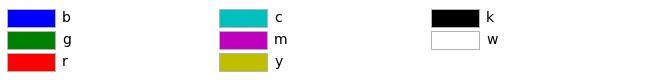

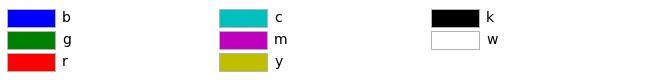

In [38]:
plot_colortable(mcolors.BASE_COLORS, ncols=3, sort_colors=False)

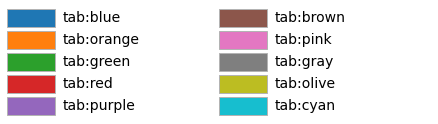

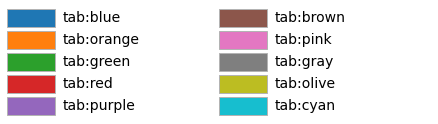

In [27]:
plot_colortable(mcolors.TABLEAU_COLORS, ncols=2, sort_colors=False)

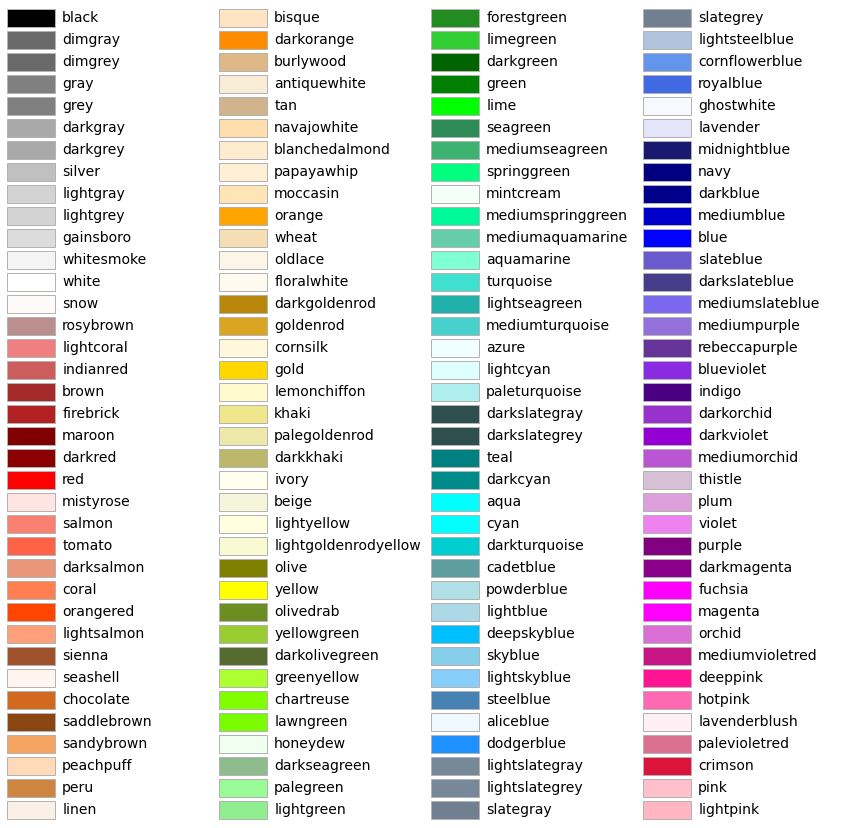

In [28]:
plot_colortable(mcolors.CSS4_COLORS)
plt.show()

###Графики, сводная таблица, вывод

In [67]:
cells_model = {0:[0,0],1:[0,1],2:[1,0],3:[1,1]}

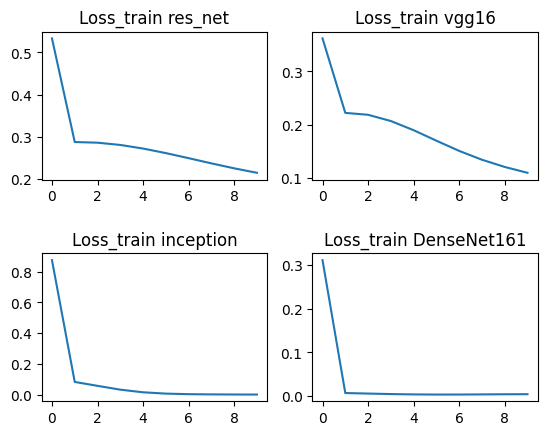

In [109]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np
import math

X = frame_models_['epoch'].unique()


figure, axis = plt.subplots(2,2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

for i,x in enumerate(frame_models['Name_model'].unique()):
  Y = frame_models[frame_models['Name_model'] == f'{x}']['spisok_train_loss']

  axis[cells_model[i][0],cells_model[i][1]].plot(X, Y)
  axis[cells_model[i][0],cells_model[i][1]].set_title(f"Loss_train {x}")

#plt.title('Loss_Train_function')
plt.show()

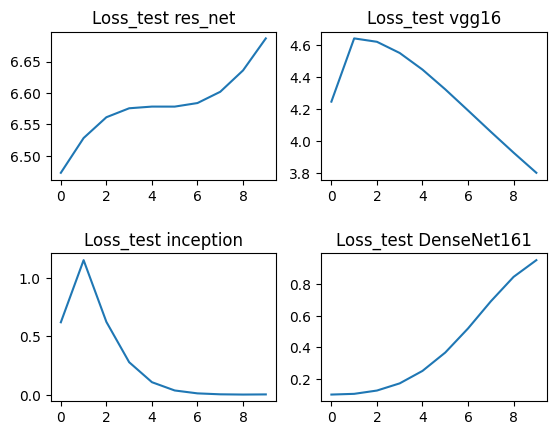

In [108]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np
import math

X = frame_models_['epoch'].unique()


figure, axis = plt.subplots(2,2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

for i,x in enumerate(frame_models['Name_model'].unique()):
  Y = frame_models[frame_models['Name_model'] == f'{x}']['spisok_test_loss']

  axis[cells_model[i][0],cells_model[i][1]].plot(X, Y)
  axis[cells_model[i][0],cells_model[i][1]].set_title(f"Loss_test {x}")

#plt.title('Loss_Train_function')
plt.show()

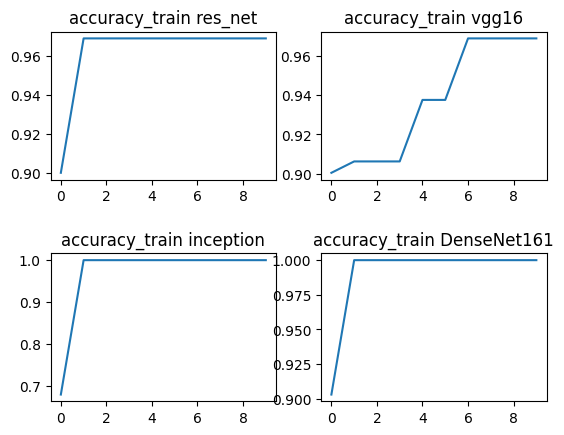

In [110]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np
import math

X = frame_models_['epoch'].unique()


figure, axis = plt.subplots(2,2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

for i,x in enumerate(frame_models['Name_model'].unique()):
  Y = frame_models[frame_models['Name_model'] == f'{x}']['spisok_train_accuracy']

  axis[cells_model[i][0],cells_model[i][1]].plot(X, Y)
  axis[cells_model[i][0],cells_model[i][1]].set_title(f"accuracy_train {x}")

#plt.title('Loss_Train_function')
plt.show()

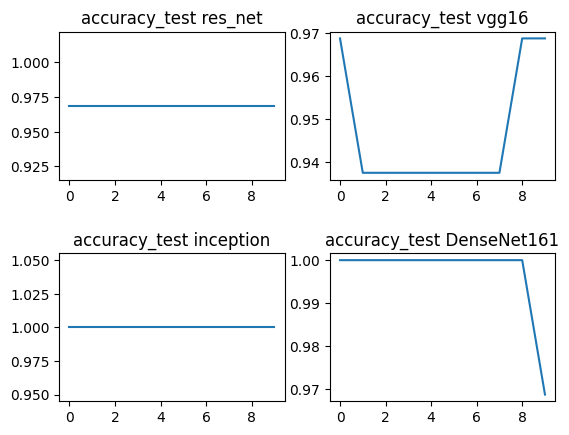

In [111]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np
import math

X = frame_models_['epoch'].unique()


figure, axis = plt.subplots(2,2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)


for i,x in enumerate(frame_models['Name_model'].unique()):
  Y = frame_models[frame_models['Name_model'] == f'{x}']['spisok_test_accuracy']

  axis[cells_model[i][0],cells_model[i][1]].plot(X, Y)
  axis[cells_model[i][0],cells_model[i][1]].set_title(f"accuracy_test {x}")

#plt.title('Loss_Train_function')
plt.show()

Видно, что модели : res_net, DenseNet - имеют сомнимые показатели на тестовых графиках лосса, что может быть связано с некачественной подборкой для валидации, так же возможным склонностям к переобучению.

#Очистка памяти

In [ ]:
del model, param, params_to_update

In [ ]:
import gc

gc.collect()

0

In [ ]:
import psutil

print(f"Загрузка CPU: {psutil.cpu_percent()}%")
print(f"Использование RAM: {psutil.virtual_memory().percent}%")

Загрузка CPU: 59.8%
Использование RAM: 16.6%


In [ ]:
import sys
sys.getsizeof(Models)

272

In [ ]:
# Общая загрузка CPU
print(f"Общая загрузка CPU: {psutil.cpu_percent()}%")

# Мониторинг загрузки каждого ядра CPU
for i, percentage in enumerate(psutil.cpu_percent(percpu=True)):
    print(f"Ядро {i}: {percentage}%")

Общая загрузка CPU: 20.5%
Ядро 0: 44.8%
Ядро 1: 74.6%


In [ ]:
import psutil
for proc in psutil.process_iter(['pid', 'name', 'username']):
    print(proc.info)

{'pid': 1, 'name': 'docker-init', 'username': 'root'}
{'pid': 6, 'name': 'node', 'username': 'root'}
{'pid': 8, 'name': 'oom_monitor.sh', 'username': 'root'}
{'pid': 10, 'name': 'run.sh', 'username': 'root'}
{'pid': 11, 'name': 'kernel_manager_proxy', 'username': 'root'}
{'pid': 37, 'name': 'tail', 'username': 'root'}
{'pid': 45, 'name': 'tail', 'username': 'root'}
{'pid': 59, 'name': 'python3', 'username': 'root'}
{'pid': 60, 'name': 'colab-fileshim.', 'username': 'root'}
{'pid': 109, 'name': 'jupyter-noteboo', 'username': 'root'}
{'pid': 110, 'name': 'dap_multiplexer', 'username': 'root'}
{'pid': 188, 'name': 'python3', 'username': 'root'}
{'pid': 232, 'name': 'python3', 'username': 'root'}
{'pid': 16157, 'name': 'sleep', 'username': 'root'}


In [ ]:
torch.cuda.empty_cache()